In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from IPython.display import Markdown, display,Image,HTML
from z3 import *

### Hooks #7

The grid above can be partitioned into 9 L-shaped “hooks”. The largest
is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains
15 squares), and so on. The smallest hook is just a single square.
Find where the hooks are located, and place nine 9’s in the largest
hook, eight 8’s in the next-largest, etc., down to one 1 in the
smallest hook.
The filled squares must form a connected region. (Squares are
“connected” if they are orthogonally adjacent.) Furthermore, every
2-by-2 region must contain at least one unfilled square.
The sum of the values in each of the
connected

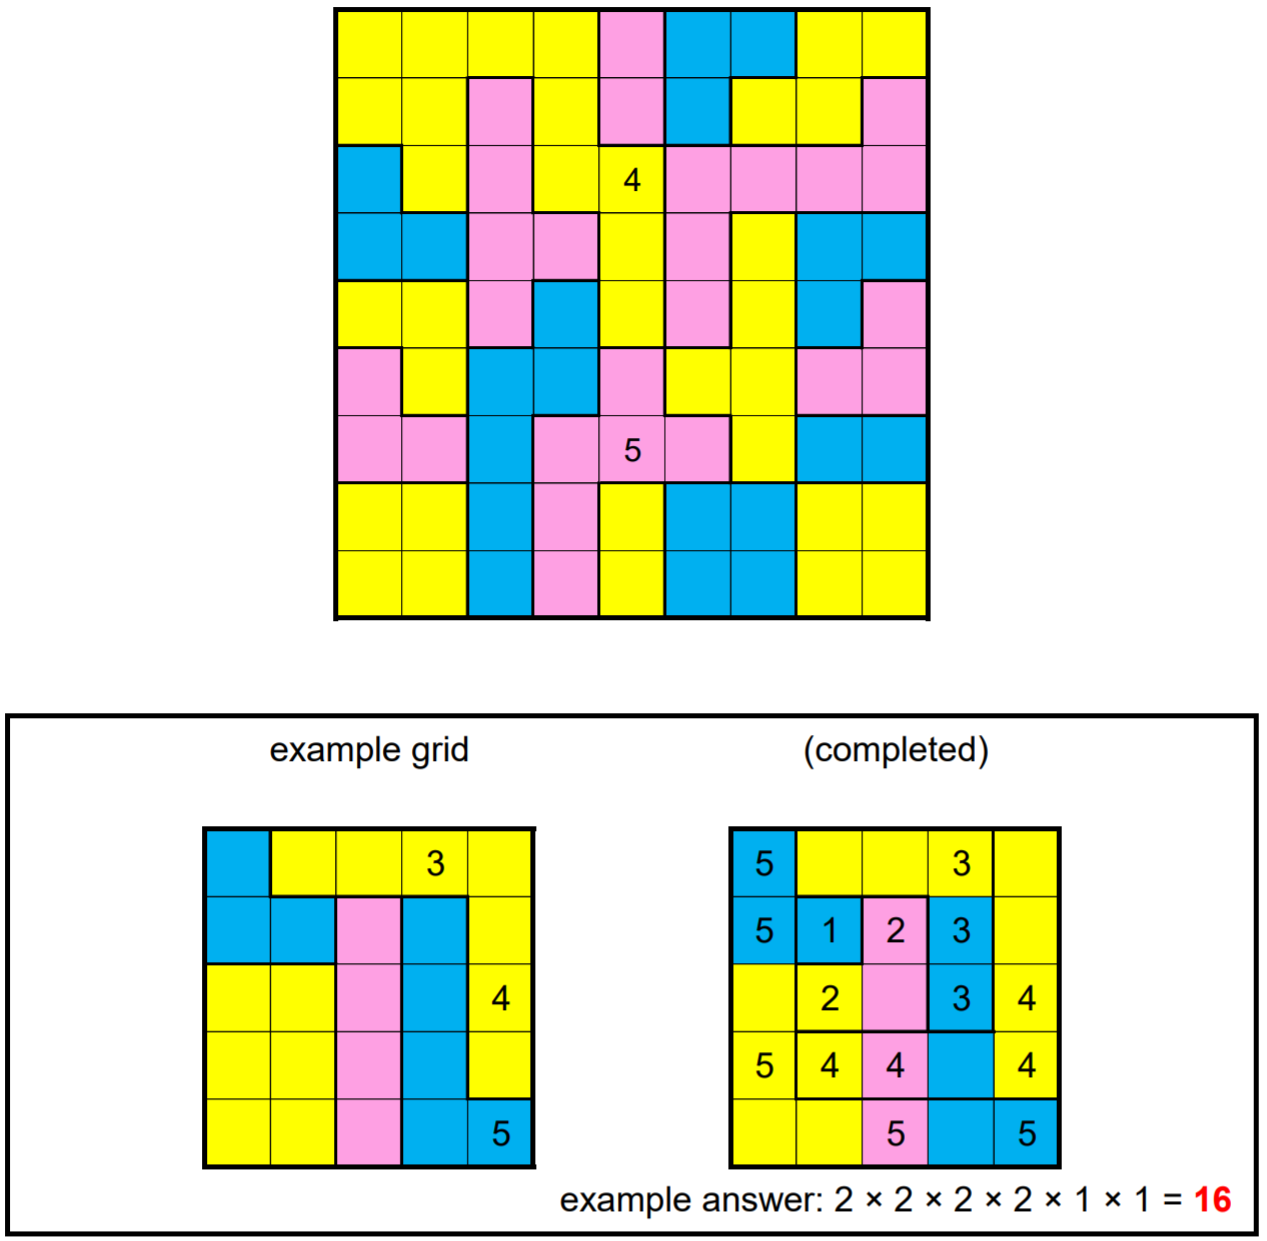

In [2]:
# Hooks again but quite different to the previous ones.
# 19 regions each which must add up to 15
# same approch as hooks #5 &#6
# -run through the hook placements to see which are allowed
# -for each hook placement check the ones that are forced by 
#  the constraints
# -solve the final cells with backtracking
# using old code from hooks #6 but adding in some numba speed ups to the checks.
# starting top right and looping cols then rows is much faster than starting top left
# and looping rows then cols

url='https://www.janestreet.com/puzzles/hooks-7-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:15]))))
display(Image('https://www.janestreet.com/puzzles/20210217_hooks_7.png',width=400))

In [3]:
# Setup the constraints
# use 20 for the filled cells and treat as smaller 
# groups with a different total
# then print the grid

groups = np.array([[0 ,0 ,0 ,0 ,1 ,2 ,2 ,3 ,3 ],
                   [0 ,0 ,6 ,0 ,1 ,2 ,3 ,3 ,4 ],
                   [5 ,0 ,6 ,0 ,0 ,4 ,4 ,4 ,4 ],
                   [5 ,5 ,6 ,6 ,0 ,4 ,8 ,9 ,9 ],
                   [7 ,7 ,6 ,16,0 ,4 ,8 ,9 ,10],
                   [18,7 ,16,16,15,8 ,8 ,10,10],
                   [18,18,16,15,15,15,8 ,11,11],
                   [17,17,16,15,14,13,13,12,12],
                   [17,17,16,15,14,13,13,12,12]                   
                 ])


def sol_print(solved,matrix,groups):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] =""
    groups_fixed = dcopy(groups)
    groups_fixed[0,2] = 0
    ax1 =sns.heatmap(solved,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=2,ax=ax[0],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax2 =sns.heatmap(groups_fixed,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,ax=ax[1],linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    plt.show()
    
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def areas(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
    print(areas)
    return np.prod(areas)

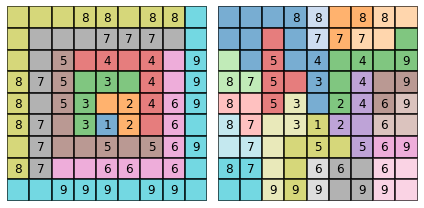

Took 2.9670 seconds
[11.  1.  5.  2.  1.  1.  5.  1.  1.  1.  1.  1.  2.  2.  1.]
solution is 2,200


In [4]:
start = time.time()
N =9
#set up the solver and variables.
s = Tactic("qffd").solver()

# H== hooks
H = np.array(IntVector("h",N**2),dtype=object).reshape((N,N))

row_fix =IntVector("r",N)
col_fix =IntVector("c",N)

s += [And(e>0,e<=N) for (i,j),e in np.ndenumerate(H)]
s += [And(e>=0,e<N) for e in row_fix+col_fix]

s += Distinct(row_fix)
s += Distinct(col_fix)

for n in range(1,N+1):
    s+=PbEq([(e==n,1) for _,e in np.ndenumerate(H)],2*n-1)
    if n!=1:
        s+=PbEq([(If(e==int(n),Sum([H[k,l] ==int(n) for k,l in neigh(i,j,N)]),0)==1,1) for (i,j),e in np.ndenumerate(H)],2)
        
for n in range(N):
    s += [Implies(e == int(n+1),Or(i == row_fix[n],j == col_fix[n])) for (i,j),e in np.ndenumerate(H)]
    

# Y = filled    
Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
s += [Or(e==0,e==1) for (i,j),e in np.ndenumerate(Y)]

for n in range(1,N+1):
    s+=PbEq([(And(e==n,Y[i,j]==1),1) for (i,j),e in np.ndenumerate(H)],n)

# no 2x2
s += [Or(Y[i,j] ==0,Y[i+1,j] ==0,Y[i,j+1] ==0,Y[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]
    
edge ={}
Z = np.array(IntVector('z', N*N),dtype=object).reshape(N,N)

# create edges and variable to define order in connectivity tree
for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N):
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s+=Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)] ==1)

# no edges into or out of unfilled cells. Only one edge per cell     
for i in range(N):
    for j in range(N):       
        s += Implies(Y[i,j] ==0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] ==0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) <= 1)
        for (k,l) in neigh(i,j,N):
            # Make edges one way to form a tree
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1

    # limit the order values
    s += [And(e>= 0 ,e <=int(N*N)) for (i,j),e in np.ndenumerate(Z)]

    # order is ascending along edges
    for i in range(N):
        for j in range(N):            
            s += [Implies(And(Y[i,j]!=0,edge[(k,l,i,j)]==1),Z[i,j] > Z[k,l]) for (k,l) in neigh(i,j,N)]

    # only one cell with no feed in => root
    s += PbEq([(And(Y[i,j] != 0,Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)

#fixed an       
s += H[2,4]*Y[2,4]==4
s += H[6,4]*Y[6,4]==5
s += And([sum([Y[i,j]*e for (i,j),e in np.ndenumerate(H) if groups[i,j] == g]) == 15 for g in range(19)])
           
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    result_x =  evalu(H)
    result_y =  evalu(Y)
    sol_print(result_x,result_y,groups)
    print("Took {:.4f} seconds".format(time.time()- start))
    soln = result_x*result_y
    print("solution is {:,.0f}".format(areas(soln)))
else:
    print("Fail")


In [5]:
url='https://www.janestreet.com/puzzles/hooks-7-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:13]))))

### Hooks #7

Show Puzzle
Here is the completed grid for this Hooks puzzle, which when you take
the product of the sizes of the empty regions gives
2200

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/20210228_hooks_7_ans-1.png" width="300" >